<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/SuperMarioBros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SuperMarioBros openAI gym 環境などのインストール

- gmy-super-mario-bros
- wandb
- 自作ライブラリ

wandb のアカウントを持っていることが前提です。

In [1]:
!wget https://raw.githubusercontent.com/aquapathos/MLLesson/master/mksmb_env.py -q
!pip install gym-super-mario-bros > /dev/null
!pip install wandb > /dev/null
!pip install stable-baselines3 > /dev/null

このインストール過程で、[nes-py](https://github.com/Kautenja/nes-py) というファミコンエミュレータがインストールされる模様。

モデルを保存するために Google Drive をマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 動作確認

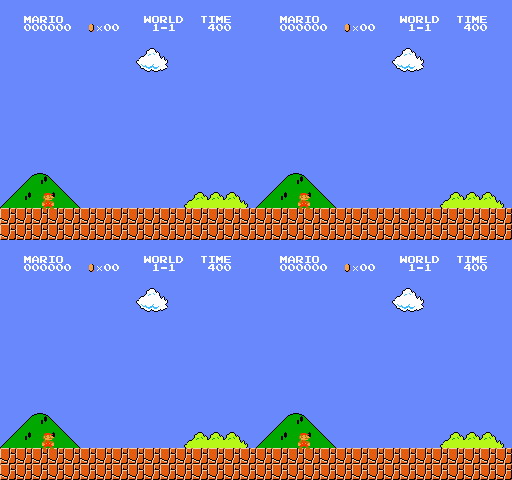

In [4]:
import gym,cv2

import gym_super_mario_bros
from mksmb_env import Joy,make_mario_env,recordModelCallback
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,COMPLEX_MOVEMENT,RIGHT_ONLY
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack

env_id = 'SuperMarioBros-v0'
#env = make_mario_env(env_id, n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir= "test")
env = make_mario_env(Joy(), n_envs=4, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= "test")
env = VecFrameStack(env, n_stack=4)

from PIL import Image 
Image.fromarray((env.render(mode='rgb_array')))

スーパーマリオのアクションスペースは256種ものアクションがあり、[JoypadSpace() ](https://github.com/Kautenja/nes-py/blob/master/nes_py/wrappers/joypad_space.py))というラッパーを通すと7種に減ることがわかる。[JoypadSpace() ](https://github.com/Kautenja/nes-py/blob/master/nes_py/wrappers/joypad_space.py)のソースを見ると、

```
    # a mapping of buttons to binary values
    _button_map = {
        'right':  0b10000000,
        'left':   0b01000000,
        'down':   0b00100000,
        'up':     0b00010000,
        'start':  0b00001000,
        'select': 0b00000100,
        'B':      0b00000010,
        'A':      0b00000001,
        'NOOP':   0b00000000,
    }
```
とあり、

```
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
```

は、[actions.py](https://github.com/Kautenja/gym-super-mario-bros/blob/1a3dde897700614f729fc3294c1e451528d9a112/gym_super_mario_bros/actions.py)で、

```
# actions for very simple movement
SIMPLE_MOVEMENT = [
    ['NOOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
    ['left'],
]
```
と定義されている。基本的にスーパーマリオは右スクロールのゲームなので、これでもよさげだが、左ジャンプぐらいもやはりほしい。upは NOOPと同じなので省いて、次のアクションスペースを使ってみる。

In [5]:
MYACTIONSET = [
    ['NOOP'],
    ['right'],
    ['right', 'A'],
    ['right', 'B'],
    ['right', 'A', 'B'],
    ['A'],
    ['left'],
    ['left', 'A'],
    ['left', 'B'],
    ['left', 'A', 'B'],
    ['down'],
]

ゲーム画面のサイズは

In [6]:
gym_super_mario_bros.make('SuperMarioBros-v0').reset().shape

(240, 256, 3)

# PPO学習

In [7]:
from stable_baselines3.common.vec_env import DummyVecEnv,SubprocVecEnv,VecFrameStack,VecEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import wandb,os
import numpy as np
import torch,gym
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(repr(device))

device(type='cpu')


In [8]:
log_dir ='/content/drive/MyDrive/M/smb'

# Inside my model training code 
!export WANDB_NOTEBOOK_NAME="Mario".ipynb"
import wandb
PROJECTNAME='Mario'
wandb.init(project=PROJECTNAME)

/bin/bash: -c: line 0: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 1: syntax error: unexpected end of file


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [11]:
from stable_baselines3.common.evaluation import evaluate_policy

def ev(lr):
    monargs={'usewandb':True}
    #env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=8, seed=0,vec_env_cls=SubprocVecEnv, monitor_dir=log_dir,monitor_kwargs=monargs)
    env = make_mario_env(Joy(movement=MYACTIONSET), n_envs=8, seed=0,vec_env_cls=DummyVecEnv, monitor_dir= log_dir,monitor_kwargs=monargs)
    env = VecFrameStack(env, n_stack=4)

    model = PPO('CnnPolicy', env, verbose=0,device=device,        
        learning_rate = lr,  # default  3e-4
        n_steps = 2048, # 2048
        clip_range = 0.2, # default 0.2
        ent_coef = 0.01, # default 0.01
        batch_size = 64, #64
        n_epochs = 4 ) # 4

    # model.load('/content/drive/MyDrive/M/smb/best_model.zip')
    callback = recordModelCallback(check_freq=50, log_dir=log_dir, usewandb=True)
    total_timesteps = 1e7
    %time model.learn(total_timesteps=total_timesteps,callback=callback)


In [ ]:
ev(2.e-3)

Num timesteps: 22800 : Best mean reward: 0.00 - Last mean reward/ep: 873.00
Saving new best model to /content/drive/MyDrive/M/smb/best_model.zip
Num timesteps: 23200 : Best mean reward: 873.00 - Last mean reward/ep: 873.00
Num timesteps: 23600 : Best mean reward: 873.00 - Last mean reward/ep: 873.00
Num timesteps: 24000 : Best mean reward: 873.00 - Last mean reward/ep: 873.00
Num timesteps: 24400 : Best mean reward: 873.00 - Last mean reward/ep: 873.00
Num timesteps: 24800 : Best mean reward: 873.00 - Last mean reward/ep: 873.00
Num timesteps: 25200 : Best mean reward: 873.00 - Last mean reward/ep: 873.00
Num timesteps: 25600 : Best mean reward: 873.00 - Last mean reward/ep: 931.50
Saving new best model to /content/drive/MyDrive/M/smb/best_model.zip
Num timesteps: 26000 : Best mean reward: 931.50 - Last mean reward/ep: 1001.67
Saving new best model to /content/drive/MyDrive/M/smb/best_model.zip
Num timesteps: 26400 : Best mean reward: 1001.67 - Last mean reward/ep: 1001.67
Num timestep

In [ ]:
!rm /content/drive/MyDrive/M/smb/?.moni*

In [ ]:
!pip install optuna
import optuna

In [ ]:
def objective(trial):
    # Loguniform parameter
    # gamma = trial.suggest_loguniform('gamma', 0.90, 0.97)
    # lr = trial.suggest_loguniform('lr', 0.001, 0.002)
    # lamda = trial.suggest_loguniform('lamda', 0.9, 0.99)
   lr = trial.suggest_loguniform('lr', 0.00001, 0.002) 
   return ev(lr)

study = optuna.create_study()
study.optimize(objective, n_trials=20)
study.best_params  # 

[I 2021-01-11 12:04:38,407] A new study created in memory with name: no-name-fa28fda1-05c0-4cce-bfdf-b4805f9a85ba


Num timesteps: 4400 : Best mean reward: 0.00 - Last mean reward/ep: 272.00
Saving new best model to /content/drive/MyDrive/M/smb/best_model.zip
Num timesteps: 4800 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 5200 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 5600 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 6000 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 6400 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 6800 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 7200 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 7600 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 8000 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 8400 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num timesteps: 8800 : Best mean reward: 272.00 - Last mean reward/ep: 272.00
Num times

[I 2021-01-11 12:10:40,895] Trial 0 finished with value: -154.0 and parameters: {'lr': 0.0016359182405151884}. Best is trial 0 with value: -154.0.


Num timesteps: 14800 : Best mean reward: 0.00 - Last mean reward/ep: 924.00
Saving new best model to /content/drive/MyDrive/M/smb/best_model.zip
Num timesteps: 15200 : Best mean reward: 924.00 - Last mean reward/ep: 924.00
Num timesteps: 15600 : Best mean reward: 924.00 - Last mean reward/ep: 924.00
Num timesteps: 16000 : Best mean reward: 924.00 - Last mean reward/ep: 924.00
CPU times: user 3min 14s, sys: 3.78 s, total: 3min 18s
Wall time: 3min 19s


[I 2021-01-11 12:14:10,056] Trial 1 finished with value: 42.20000076293945 and parameters: {'lr': 1.9560628221890964e-05}. Best is trial 0 with value: -154.0.


CPU times: user 3min 15s, sys: 2.74 s, total: 3min 18s
Wall time: 3min 18s


[I 2021-01-11 12:17:37,640] Trial 2 finished with value: 36.099998474121094 and parameters: {'lr': 0.0008343665904722193}. Best is trial 0 with value: -154.0.
